# CS 363M Machine Learning Project

## Authors
- Hudson Gould (HAG929)
- Cristian Cantu (cjc5844)
- Diego Costa (dc48222)
- Dylan Dang (dad4364)

## Background
In this project, we are using data from the UT Baseball 2024 Season. Our dataset contains data from every single pitch during UT home games, taken from a TrackMan brand detection machine which tracks and records 3D characteristic of a baseball in motion.

We want to use this data to predict whether a given pitch will be a home run or not. We will use information such as the pitch velocities to predict this.

## Data Preparation

### Import packages

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as spstats
import seaborn as sns
%matplotlib inline

### Data Cleaning

#### Print head of the data

In [ ]:
data = pd.read_csv('data_10k.csv')

data.head()

columns_to_keep = [
    # target and core features
    'PlayResult',  
    'RunsScored',          
    'RelSpeed',            
    'SpinRate',            
    'SpinAxis',            
    'ExitSpeed',           
    'Angle',               
    'Distance',            
    'HangTime',           
    'VertBreak',          
    'InducedVertBreak',    
    'HorzBreak',           
    'PlateLocHeight',      
    'PlateLocSide',        
    'Direction',           

    'MaxHeight',           
    'MeasuredDuration',    
    'SpeedDrop',           
    'ContactPositionX', 'ContactPositionY', 'ContactPositionZ', 
    'HitSpinAxis',         
    'HitTrajectoryXc0', 'HitTrajectoryXc1', 'HitTrajectoryXc2',  
    'HitTrajectoryYc0', 'HitTrajectoryYc1', 'HitTrajectoryYc2',  
    'HitTrajectoryZc0', 'HitTrajectoryZc1', 'HitTrajectoryZc2'   
]

data = data[columns_to_keep]

,game_id,Date,Time,PitchNo,Inning,inning_half,PAofInning,PitchofPA,Pitcher,PitcherId,...,z0,vx0,vy0,vz0,ax0,ay0,az0,catcher,catcher_id,catcher_team
0,20240220-HighPointUniversity-1,2/20/2024,60314,82,3,Top,4,2,"Olsovsky, Dalton",1000251274,...,5.41,3.28,-106.58,0.58,12.91,22.07,-34.04,"Ruiz, Justin",1000208999,HIG_PAN
1,20240220-HighPointUniversity-1,2/20/2024,63576,185,6,Top,2,3,"Glover, Lucas",1000138461,...,6.01,5.23,-118.11,-3.37,3.74,26.71,-27.88,"Ruiz, Justin",1000208999,HIG_PAN
2,20240220-HighPointUniversity-1,2/20/2024,66446,269,8,Top,3,1,"Carter, Noah",1000108939,...,5.52,3.08,-122.94,-1.77,-3.68,24.28,-16.89,"Grintz, Eric",686456,HIG_PAN
3,20240220-HighPointUniversity-1,2/20/2024,64809,216,6,Bottom,6,1,"Welch, Collin",1000192105,...,6.23,0.38,-117.74,-0.37,-12.27,24.59,-28.63,"Church, Braxton",1000192101,APP_MOU
4,20240220-HighPointUniversity-1,2/20/2024,67985,308,9,Bottom,4,3,"Lewis, Zach",1000127413,...,5.18,9.62,-132.57,-10.20,-8.59,32.05,-14.93,"Church, Braxton",1000192101,APP_MOU


### Data Exploration

In [ ]:
cols = data.select_dtypes(include=['object', 'category']).columns
cols = cols.drop(['game_id', 'Pitcher', 'PitcherTeam', 'Batter', 'BatterTeam', 'catcher', 'catcher_team'])

max_col_width = max(len(col) for col in cols)

for col in cols:
    print(f'{col:<{max_col_width}}: {data[col].unique()}')

Date           : ['2/20/2024' '2/21/2024']
inning_half    : ['Top' 'Bottom']
PitcherThrows  : ['R' 'L']
BatterSide     : ['R' 'L']
PitchCall      : ['StrikeCalled' 'HitByPitch' 'BallCalled' 'InPlay' 'FoulBall'
 'StrikeSwinging' 'BallinDirt' 'FoulBallNotFieldable' 'BallIntentional'
 'FoulBallFieldable']
PlayResult     : ['Undefined' 'Strikeout' 'Single' 'FieldersChoice' 'Out' 'Double' 'Walk'
 'Sacrifice' 'HomeRun' 'Error' 'Triple' 'StolenBase' 'CaughtStealing']
KorBB          : ['Undefined' 'Strikeout' 'Walk']
TaggedPitchType: ['Slider' 'Fastball' 'ChangeUp' 'Curveball' 'Sinker' 'Cutter'
 'Knuckleball' 'Changeup' 'Four-Seam' nan 'Splitter' 'FourSeamFastBall'
 'TwoSeamFastBall']
TaggedHitType  : [nan 'fly_ball' 'line_drive' 'pop_up' 'ground_ball']


In [50]:
# print number of missing values in each column
missing = data.isnull().sum()
print(missing[missing > 0])

TaggedPitchType                30
RelSpeed                       48
SpinRate                       58
SpinAxis                       48
Tilt                           48
InducedVertBreak               48
VertBreak                      48
HorzBreak                      48
VertApprAngle                  48
HorzApprAngle                  48
vert_rel_angle                 48
horz_rel_angle                 48
RelHeight                      48
RelSide                        48
Extension                      52
PlateLocHeight                 48
PlateLocSide                   48
zone_time                      48
EffectiveVelo                  48
SpeedDrop                      48
TaggedHitType                7507
hit_x                        8219
hit_y                        8219
ExitSpeed                    7507
Angle                        7507
HitSpinRate                  8146
hit_spin_axis                8306
Distance                     8219
hit_last_tracked_distance    7507
hit_hang_time 

In [52]:
print(data['PlayResult'].value_counts())

PlayResult
Undefined         7495
Out                835
Strikeout          575
Single             388
Walk               323
Double             118
HomeRun             66
Sacrifice           54
FieldersChoice      47
Error               46
StolenBase          28
CaughtStealing      13
Triple              11
Name: count, dtype: int64


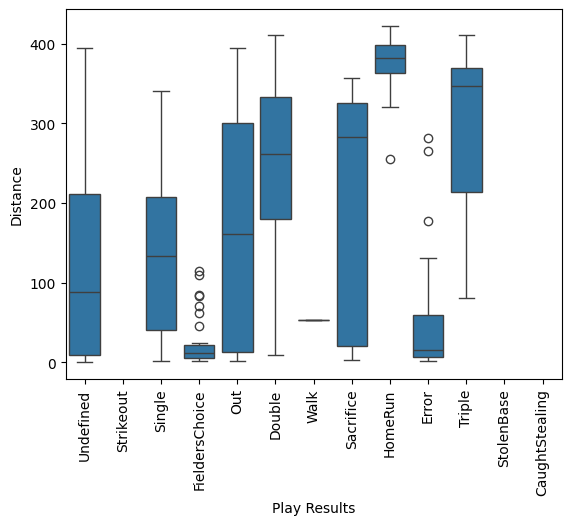

In [9]:
plt.figure()
sns.boxplot(x='PlayResult', y='Distance', data=data)
plt.xlabel('Play Results')
plt.ylabel('Distance')
plt.xticks(rotation=90)
plt.show()

In [ ]:
data = pd.read_csv('data_10k.csv')

# Trying to plot a heatmap of correlations between all the features and PlayResult = Homerun
import pandas as pd

# Ensure IsHomeRun is defined as a binary column
data['IsHomeRun'] = (data['PlayResult'] == 'HomeRun').astype(int)

# Select numerical columns
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns

# Calculate correlations with IsHomeRun
home_run_corr = data[numerical_features].corr()['IsHomeRun'].sort_values(ascending=False)

# Display the correlations
pd.set_option('display.max_rows', None)
print(home_run_corr)

IsHomeRun                    1.000000
RunsScored                   0.526636
hit_last_tracked_distance    0.337569
Distance                     0.327059
hit_y                        0.315036
hit_hang_time                0.246433
ExitSpeed                    0.198423
hit_max_height               0.153468
position_110x                0.070841
hit_contact_x                0.068017
Angle                        0.042155
position_110y                0.039385
PitchofPA                    0.037337
Balls                        0.028325
Strikes                      0.025754
PitcherId                    0.016385
HorzBreak                    0.015899
catcher_id                   0.014210
Extension                    0.013043
InducedVertBreak             0.012919
pfxz                         0.012479
VertApprAngle                0.012105
az0                          0.010826
VertBreak                    0.010763
SpinAxis                     0.009017
PAofInning                   0.008517
HorzApprAngl

### Feature Engineering

## Modeling

### Decision Trees (Cristian)

### Neural Nets (Hudson)

### SVM

## Outcome